In [282]:
referensi = {
    'https://www.quora.com/How-can-I-choose-the-best-K-in-KNN-K-nearest-neighbour-classification',
    'https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657',
    'https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/',
    'https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn',
    'https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/',
    'https://stackoverflow.com/questions/22132525/add-column-with-number-of-days-between-dates-in-dataframe-pandas'
}

In [283]:
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, KDTree, BallTree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from datetime import date, datetime
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [284]:
pd.set_option('display.max_rows', 50)
coronaColumns = [
    'id',
    'sex',
    'birth_year',
    'country',
    'region',
    'disease',
    'group',	
    'infection_reason',	
    'infection_order',
    'infected_by',
    'contact_number',
    'confirmed_date',	
    'released_date',
    'deceased_date',	
    'state'
]

#print(len(coronaColumns))
corona = pd.read_csv("patient.csv", header=None)
corona = corona.iloc[1:]
corona.columns = coronaColumns

In [285]:
print("Jumlah atribut: {}".format(corona.shape[1]))
print("Jumlah data: {}".format(corona.shape[0]))
print("Jumlah data tak valid: {}".format(corona.shape[0] - corona.dropna().shape[0]))

Jumlah atribut: 15
Jumlah data: 7513
Jumlah data tak valid: 7513


In [286]:
uniqueValues = []
percentUniqueValues = []
missingValues = corona.isnull().sum()
percent_missing = corona.isnull().sum() * 100 / len(corona)

for column in corona.columns:
    uniqueValue = corona[column].nunique() 
    uniqueValues.append(uniqueValue)
    percentUniqueValues.append(uniqueValue * 100 / len(corona))

coronaValuesInfo = pd.DataFrame({
    'column name': corona.columns,
    '# unique values': uniqueValues,
    '% unique values': percentUniqueValues,
    '# missing values': missingValues,
    '% missing values':  percent_missing
})

coronaValuesInfo

column name  # unique values  % unique values  \
id                              id             7513       100.000000   
sex                            sex                2         0.026621   
birth_year              birth_year               80         1.064821   
country                    country                3         0.039931   
region                      region               14         0.186344   
disease                    disease                1         0.013310   
group                        group                5         0.066551   
infection_reason  infection_reason               12         0.159723   
infection_order    infection_order                6         0.079862   
infected_by            infected_by               41         0.545721   
contact_number      contact_number               35         0.465859   
confirmed_date      confirmed_date               35         0.465859   
released_date        released_date               20         0.266205   
deceased_date        deceased_date               16         0.212964   
state                        state                3         0.039931   

                  # missing values  % missing values  
id                               0          0.000000  
sex                           6851         91.188606  
birth_year                    6864         91.361640  
country                          0          0.000000  
region                        7092         94.396380  
disease                       7485         99.627313  
group                         7431         98.908558  
infection_reason              7369         98.083322  
infection_order               7478         99.534141  
infected_by                   7443         99.068282  
contact_number                7463         99.334487  
confirmed_date                   0          0.000000  
released_date                 7458         99.267936  
deceased_date                 7477         99.520831  
state                            0          0.000000

In [287]:
# Membuang row yang memiliki kurang dari 5 non-missing values 
# Membuang kolom yang memiliki missing values > 94% data keseluruhan
limit = len(corona) * 0.06
corona = corona.dropna(thresh=5, axis=0)
corona = corona.dropna(thresh=limit, axis=1)

In [288]:
# Membuang kolom id karena hanya sebagai identifier
corona.drop(['id'], axis=1, inplace=True)

In [289]:
# Mengubah nilai NaN pada birth year menjadi 1915, agar dapat terlihat di scatterplot
# Mengubah tipe data string menjadi integer pada kolom birth_year
# Mengencode kolom sex dan country
corona['birth_year'] = corona['birth_year'].replace(np.nan, 1915, regex=True)
corona['birth_year'] = corona['birth_year'].astype(int)

corona.replace({
    'sex' : {
        'female': 0, 
        'male': 1
    }
}, inplace=True)

corona.replace({
    'country' : {
        'China' : 0, 
        'Korea' : 1, 
        'Mongolia' : 2
    }
}, inplace=True)

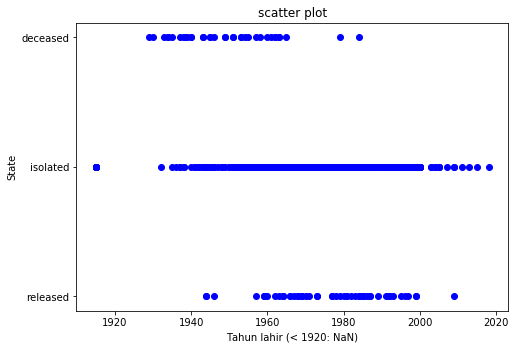

In [290]:
# Menampilkan scatterplot birth year terhadap state dari pasien
state = corona['state']
birthYear = corona['birth_year']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(birthYear, state, color='b')
ax.set_xlabel('Tahun lahir (< 1920: NaN)')
ax.set_ylabel('State')
ax.set_title('scatter plot')
fig.savefig('scatterplot_usia_state.png', dpi=200)

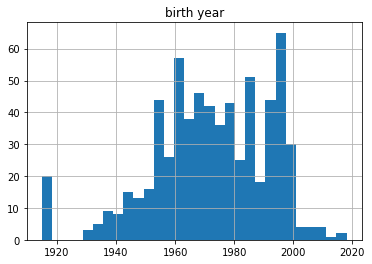

In [291]:
# Menampilkan histogram tentang banyaknya kasus terhadap pasien yang 
# lahir pada tahun tertentu.
histogramDF = pd.DataFrame({
    #'state': state,
    'birth year': birthYear
    } )
histogram = histogramDF.hist(bins=30)

In [292]:
bins = []
for year in range(1925, 2021, 5):
    bins.append(year)
birthYear= []

corona['birth_year'].values
corona['binned_birth_year'] = pd.cut(x=corona['birth_year'], bins=bins)
#corona.drop(['confirmed_date', 'id','binned_birth_year'], axis=1, inplace=True)
#birthYear

In [293]:
# Mengubah tipe data string pada kolom confirmed_date ke tipe datetime
corona['confirmed_date'] = pd.to_datetime(corona['confirmed_date'])

date_today = []
# Karena data ini didownload pada tanggal 10 Maret 2020, maka date_today akan
# berisi tanggal 10 Maret 2020 yang akan dipakai untuk menghitung sudah berapa
# hari pasien terinfeksi.
for i in range(len(corona)):
    date_today.append(datetime(2020, 3, 10).strftime("%Y-%m-%d"))


In [294]:
corona

sex  birth_year  country confirmed_date     state binned_birth_year
1     0.0        1984        0     2020-01-20  released      (1980, 1985]
2     1.0        1964        1     2020-01-24  released      (1960, 1965]
3     1.0        1966        1     2020-01-26  released      (1965, 1970]
4     1.0        1964        1     2020-01-27  released      (1960, 1965]
5     1.0        1987        1     2020-01-30  released      (1985, 1990]
...   ...         ...      ...            ...       ...               ...
5581  1.0        2013        1     2020-03-04  isolated      (2010, 2015]
5767  1.0        1938        1     2020-03-05  deceased      (1935, 1940]
5768  0.0        1935        1     2020-03-05  deceased      (1930, 1935]
6285  0.0        1929        1     2020-03-06  deceased      (1925, 1930]
7196  1.0        1945        1     2020-03-08  deceased      (1940, 1945]

[669 rows x 6 columns]

In [295]:
pdDateToday = pd.Series(date_today)
pdDateToday = pd.to_datetime(pdDateToday)
corona['today_date'] = pdDateToday

# Entah mengapa terdapat nilai NaT, maka saya perlu mengisinya lagi dengan 
# tanggal 10 Maret 2020.
fill = pd.to_datetime('2020-03-10')
corona['today_date'] = corona['today_date'].fillna(fill)



In [296]:
# Memberi kolom baru yang berisi jumlah hari setelah pasien terinfeksi
daysAfterInfection = (corona['today_date'] - corona['confirmed_date']).dt.days
corona['days'] = daysAfterInfection


In [297]:
corona.drop(['binned_birth_year', 'today_date', 'confirmed_date'], axis=1, inplace=True)
corona.fillna(corona.mean(), inplace=True)

#corona

In [298]:
# Mendrop kolom yang berisi tanggal, sehingga hanya menyisakan
# kolom yang berisi jumlah hari setelah infeksi terjadi
coronaFeatures = corona.drop(['state'], axis=1, inplace=False)
coronaLabel = corona['state']

coronaFeatures

sex  birth_year  country  days
1     0.0        1984        0    50
2     1.0        1964        1    46
3     1.0        1966        1    44
4     1.0        1964        1    43
5     1.0        1987        1    40
...   ...         ...      ...   ...
5581  1.0        2013        1     6
5767  1.0        1938        1     5
5768  0.0        1935        1     5
6285  0.0        1929        1     4
7196  1.0        1945        1     2

[669 rows x 4 columns]

In [299]:
# Membagi data menjadi feature/atribut dan label/target, kemudian
# membagi lagi menjadi data training dan data testing dengan
# test sizenya sebesar 20%
coronaXTrain, coronaXTest, coronaYTrain, coronaYTest = train_test_split(coronaFeatures, coronaLabel, test_size=0.2)

In [300]:
# Mencari nilai k ganjil yang terbaik menggunakan GridSearchCV
# https://www.quora.com/Does-the-k-in-kNN-usually-or-must-be-an-odd-number-Or-it-depends-on-the-number-of-classes
# Harap bersabar menunggu hasil pencarian k yang baik karena dapat memakan waktu
# kira-kira 30 detik
kValues = []
for value in range(1, 30):
    kValues.append(value)

grid_params = {
    'n_neighbors': kValues,
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=3, n_jobs=-1)
gs_results = gs.fit(coronaXTrain, coronaYTrain)

bestParameters = gs_results.best_params_
k = bestParameters['n_neighbors']

Fitting 3 folds for each of 116 candidates, totalling 348 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 348 out of 348 | elapsed:   12.1s finished


In [301]:
# Menampilkan nilai k terbaik, beserta dengan parameter-parameter lainnya
print("Best score:\n", gs_results.best_score_)
print("Best estimator:\n", gs_results.best_estimator_)
print("Best parameter:\n", gs_results.best_params_)

knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(coronaXTrain, coronaYTrain)

coronaKNNScore = knn.score(coronaXTest, coronaYTest) * 100.0
print("Accuracy KNN Coronavirus untuk k={}: {} %".format(k, coronaKNNScore))

Best score:
 0.9084175506873392
Best estimator:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')
Best parameter:
 {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Accuracy KNN Coronavirus untuk k=11: 91.04477611940298 %


In [302]:
# Melakukan prediksi menggunakan Naive Bayes
coronaNaiveBayes = GaussianNB()
coronaNaiveBayes.fit(coronaXTrain, coronaYTrain)
coronaYPrediction = coronaNaiveBayes.predict(coronaXTest)
accuracy = metrics.accuracy_score(coronaYTest, coronaYPrediction) * 100.0
print("Akurasi menggunakan Naive Bayes untuk data Coronavirus: {} %".format(accuracy)) 


Akurasi menggunakan Naive Bayes untuk data Coronavirus: 89.55223880597015 %
